In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np 
import json
from dataclasses import dataclass, field

In [2]:
import os
code_dir = Path().cwd().parent
os.chdir(code_dir)

In [3]:
import functions as funcs

In [4]:
with open(Path()/'Synth' / r"labels_basos_2023-11-01-11-49-24.json") as f:
    basos_anno_json = json.load(f)

In [5]:
# Get the Baso images in the train and val folders
baso_nno_keys = basos_anno_json.keys()
baso_nno_keys

dict_keys(['B014_77I_T19095_RT_x40_z0_i02j07.jpg', 'B034_8A7_T19084_RT_x40_z0_i14j32.jpg', 'B034_8A7_T19084_RT_x40_z0_i22j26.jpg', 'N19120_2I1_N19120_RT_x40_z0_i01j20.jpg'])

In [6]:
# Get the baso images from the test and val folders 

root_folder = Path().cwd().parent
yolo_folder = root_folder /"Yolo"

baso_image_paths = []

for folder in ['test', 'val']:
    images_dir = yolo_folder/folder/'images'
    assert images_dir.is_dir(), "Folder not found"
    for file in images_dir.iterdir():
        if (file.is_file()) & (file.suffix in [".jpeg", ".jpg"]):
            if file.parts[-1] in baso_nno_keys:
                baso_image_paths.append(file)
baso_image_paths

[WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/Yolo/test/images/N19120_2I1_N19120_RT_x40_z0_i01j20.jpg'),
 WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/Yolo/val/images/B034_8A7_T19084_RT_x40_z0_i22j26.jpg')]

In [7]:
baso_images = [funcs.get_image_from_path(file_path=file_path) for file_path in baso_image_paths]

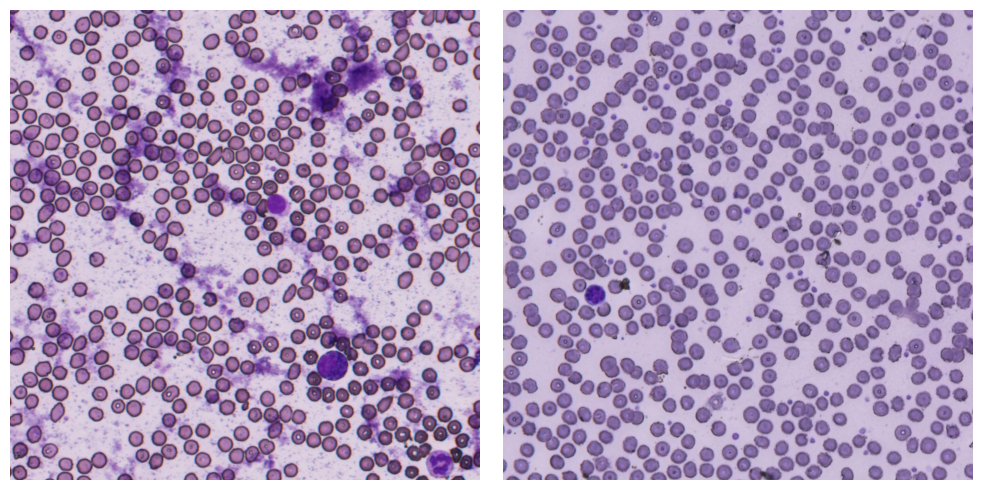

In [8]:
_, ax = plt.subplots(nrows=1, ncols=len(baso_images), figsize=(10,5))
for col, img in enumerate(baso_images):
    ax[col].imshow(img)
    ax[col].axis('off')
plt.tight_layout()
plt.show()

In [9]:
@dataclass
class ImageCell:
    cell_label:str
    all_points_x:list[float]
    all_points_y:list[float]

@dataclass
class ImageData:
    image_path:Path
    cells:list[ImageCell] = None

In [10]:
def get_image_data(image_annotations:json, image_path:Path) -> ImageData:
    """ Returns the polygon coordinates of an images given annotation 
    """
    image_name = image_path.parts[-1]
    assert image_name in image_annotations.keys(), "image_name not in annotations"
    
    image_data = ImageData(image_path=image_path)
    image_data.image_path = image_path

    for region in image_annotations[image_name]['regions']:
        region_attributes = image_annotations[image_name]['regions'][region]['region_attributes']
        all_points_x = image_annotations[image_name]['regions'][region]['shape_attributes']['all_points_x']
        all_points_y = image_annotations[image_name]['regions'][region]['shape_attributes']['all_points_y']
        image_cell = ImageCell(cell_label=region_attributes['label'], all_points_x=all_points_x, all_points_y=all_points_y)
        
        image_data.cells = [image_cell] if image_data.cells == None else image_data.cells + [image_cell] 
    return image_data


In [11]:
image_data = [get_image_data(image_annotations=basos_anno_json, image_path=file_path) for file_path in baso_image_paths]
image_data

[ImageData(image_path=WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/Yolo/test/images/N19120_2I1_N19120_RT_x40_z0_i01j20.jpg'), cells=[ImageCell(cell_label='B', all_points_x=[660.8751608751609, 693.0501930501931, 721.3642213642214, 720.0772200772201, 702.0592020592021, 669.8841698841699, 649.2921492921492, 646.7181467181467, 660.8751608751609], all_points_y=[725.8687258687258, 718.1467181467182, 738.7387387387388, 772.2007722007722, 792.7927927927929, 791.5057915057915, 765.7657657657658, 750.3217503217503, 725.8687258687258]), ImageCell(cell_label='L', all_points_x=[554.0540540540541, 574.6460746460747, 592.6640926640927, 593.951093951094, 569.4980694980695, 542.4710424710424, 538.6100386100386, 542.4710424710424, 554.0540540540541], all_points_y=[384.8133848133848, 386.1003861003861, 400.25740025740026, 431.14543114543113, 441.44144144144144, 433.7194337194337, 409.26640926640925, 397.6833976833977, 384.8133848133848])]),
 ImageData(image_path=WindowsPath('c:/Users/

In [12]:
# Get the ROI with black background
roi_boxes = []
for id in image_data:
    img1 = funcs.get_image_from_path(id.image_path)
    for cell in id.cells:
        if cell.cell_label == 'B':
            pts = [np.array([int(x), int(y)], dtype=np.int32) for (x, y) in zip(cell.all_points_x, cell.all_points_y)]
            pts_array = np.array([pts], dtype=np.int32)
            mask = np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8)
            cv2.fillPoly(img=mask, pts=pts_array, color=(255, 255, 255))
            roi = cv2.bitwise_and(img1, img1, mask=mask)
            
            xs = [p[0] for p in pts]
            ys = [p[1] for p in pts]
            x_max = np.max(xs)
            x_min = np.min(xs)
            y_max = np.max(ys)
            y_min = np.min(ys)
            roi_box = roi[y_min : y_max + 1, x_min : x_max + 1] 
            roi_boxes.append(roi_box)
            

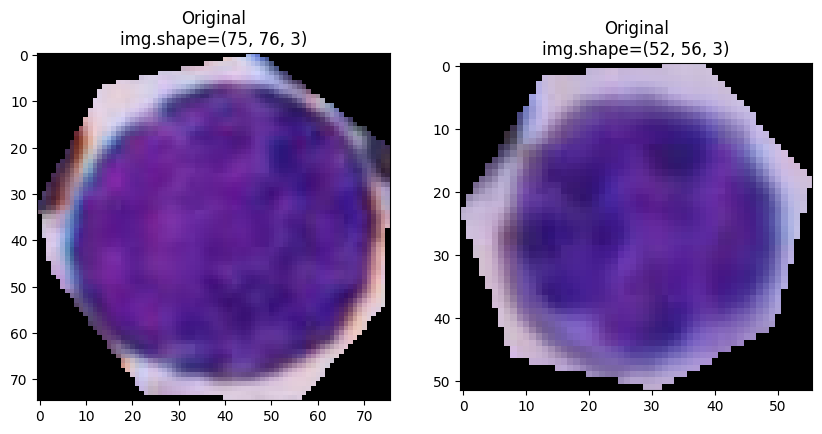

In [13]:
_, ax = plt.subplots(nrows=1, ncols=len(roi_boxes), figsize=(10,5))
for col, img in enumerate(roi_boxes):
    ax[col].imshow(img)
    ax[col].set_title(f"Original\n{img.shape=}")
# plt.tight_layout()
plt.show()

In [210]:
img_boxes = []
for id in image_data:
    img = funcs.get_image_from_path(id.image_path)
    for cell in id.cells:
        if cell.cell_label == 'B':
            pts = [np.array([int(x), int(y)], dtype=np.int32) for (x, y) in zip(cell.all_points_x, cell.all_points_y)]
            pts_array = np.array([pts], dtype=np.int32)
            xs = [p[0] for p in pts]
            ys = [p[1] for p in pts]
            x_max = np.max(xs)
            x_min = np.min(xs)
            y_max = np.max(ys)
            y_min = np.min(ys)
            roi_box = img[y_min : y_max + 1, x_min : x_max + 1]
            img_boxes.append(roi_box)

In [362]:
len(img_boxes)

2

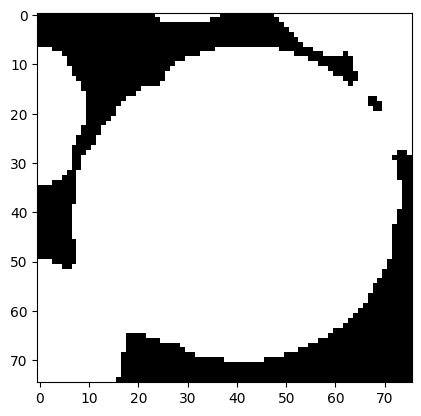

In [363]:
img_box = img_boxes[0]
img_green = img_box[:,:,1]
img_med_filt = cv2.medianBlur(src=img_green, ksize=3)
_, binary_img = cv2.threshold(img_med_filt, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
eroded = cv2.erode(src=binary_img,kernel=(5,5), iterations=3)



plt.imshow(binary_img, cmap='gray')
plt.show()

In [364]:
from skimage.segmentation import watershed, felzenszwalb
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

In [377]:
distance = ndi.distance_transform_edt(binary_img)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary_img)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=binary_img)

In [374]:
max_label = np.bincount(labels.flatten()).argmax()
max_label

10

In [375]:
green_label = np.where(labels == max_label)

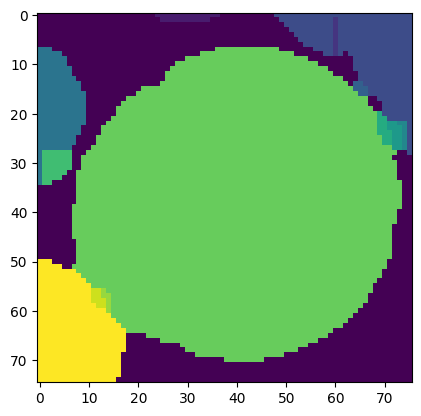

In [376]:
plt.imshow(labels)
plt.show()

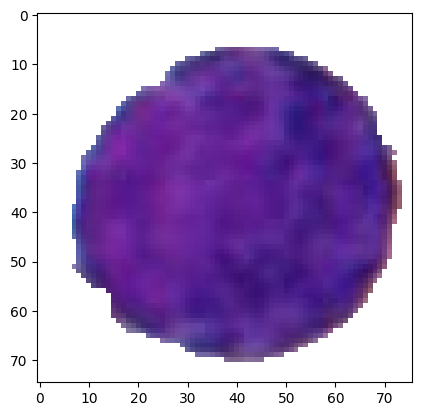

In [369]:
mat = np.ones_like(img_box, dtype=np.int32) * 255
mat[green_label[0], green_label[1]] = img_box[green_label[0], green_label[1]]

plt.imshow(mat)
# plt.imshow(img_box)
plt.show()

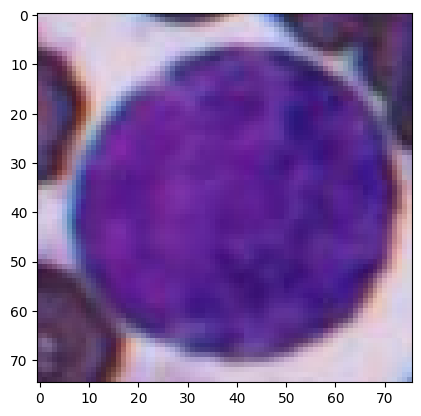

In [370]:
plt.imshow(img_box)
plt.show()

In [378]:
import imutils


ModuleNotFoundError: No module named 'imutils'

In [387]:
# Create a copy of the original image
image_with_circle = img_box.copy()

for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(img_box.shape[:2], dtype="uint8")
    mask[labels == label] = 255
    # detect contours in the mask and grab the largest one
    contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # max_radius = -np.inf
	for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        # Convert the radius to integer
        radius = int(radius)
        # Draw the circle on the image
        cv2.circle(image_with_circle, center, radius, (0, 255, 0), 1)

plt.imshow(image_with_circle)
plt.show()


TabError: inconsistent use of tabs and spaces in indentation (1775492246.py, line 16)

In [21]:
def get_image_augmentations(img:np.ndarray) -> list[np.ndarray]:
    """ Returns a list of augmented images 
    """
    augs = []
    augs.append(cv2.resize(img, dsize=(50,50)))
    augs.append(cv2.resize(img, dsize=(75,75)))
    # for img in augs.copy():
    #     img_copy = img.copy()
    #     img_copy2 = img.copy()
    #     mask = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    #     mask[mask > 0] = 255
    #     light_img = cv2.convertScaleAbs(img_copy, alpha=1.5, beta=30)
    #     light_img = cv2.bitwise_and(light_img, light_img, mask=mask)
    #     augs.append(light_img)
    #     dark_img = cv2.convertScaleAbs(img_copy2, alpha=1, beta=-30)
    #     dark_img = cv2.bitwise_and(dark_img, dark_img, mask=mask)
    #     augs.append(dark_img)
    
    for img in augs.copy():
        crop_top, crop_bottom, crop_left, crop_right = [img.copy() for _ in range(4)]
        img_height, img_width = img.shape[0], img.shape[1]
        height_qtr = int(0.25 * img_height)
        width_qtr = int(0.25 * img_width)
        crop_top[:height_qtr,:,:] = 0 
        augs.append(crop_top)
        crop_bottom[-height_qtr:,:,:] = 0
        augs.append(crop_bottom)
        crop_left[:,:width_qtr,:] = 0
        augs.append(crop_left)
        crop_right[:,-width_qtr:,:] = 0
        augs.append(crop_right)
        
    
    return augs

In [23]:
au = get_image_augmentations(img=roi_boxes[0])

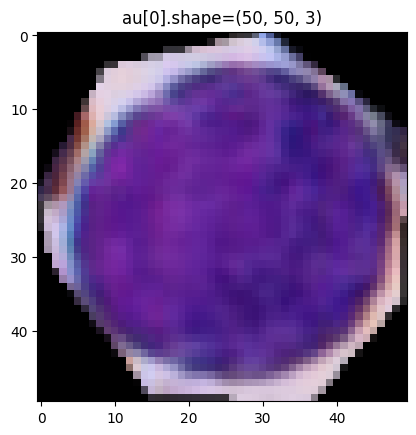

In [91]:
plt.imshow(au[0])
plt.title(f"{au[0].shape=}")
plt.show()

In [38]:
def make_binary_image(img: np.ndarray) -> np.ndarray:
    """ Takes an image applies filters and thresholding 
        and returns an inverted binary image
    """
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # clahe = cv2.createCLAHE(clipLimit=5)
    # apply_clahe = clahe.apply(gray_img) +10
    _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # kernel = np.ones((5, 5), np.uint8)
    # dilated_img = cv2.dilate(binary_img, kernel, iterations=1)  
    # inverted_binary = cv2.bitwise_not(dilated_img)
    return binary_img


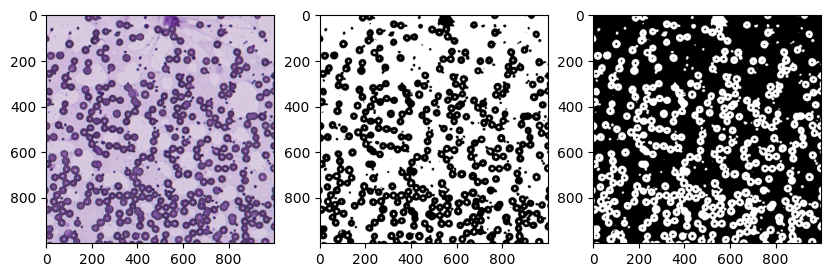

In [125]:
no_wbc_dir = Path().cwd().parent / r"AI Training Sets-20231024T092556Z-001"/r"AI Training Sets"/"No_WBCs_Images"
no_wbc_img_name = "A002_04I_T15079_MID_x40_z0_i21j04.jpg"
no_wbc_img = funcs.get_image_from_path(file_path=no_wbc_dir/no_wbc_img_name)
no_wbc_bin_img = make_binary_image(img=no_wbc_img)
inverted_mask = cv2.bitwise_not(no_wbc_bin_img)


_, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
ax[0].imshow(no_wbc_img)
ax[1].imshow(no_wbc_bin_img, cmap='gray')
ax[2].imshow(inverted_mask, cmap='gray')
plt.show()

In [146]:
def get_roi_indices(roi: np.ndarray) -> tuple:
    """ Gets the ROI indices for image augmentations
    """
    # White area contains ROI, black background
    non_zero_mask = np.any(roi != [0, 0, 0], axis=2)
    white_mask = non_zero_mask * 255
    image_indices = np.where(white_mask != 0)

    # Get the start and end index of image
    row_start, row_end = np.min(image_indices[0]), np.max(image_indices[0] + 1)
    col_start, col_end = np.min(image_indices[1]), np.max(image_indices[1] + 1)
    row_offset, col_offset = row_end - row_start, col_end - col_start

    return image_indices, row_start, row_offset, col_start, col_offset


In [148]:
image_indices, row_start, row_offset, col_start, col_offset = get_roi_indices(roi=au[0])

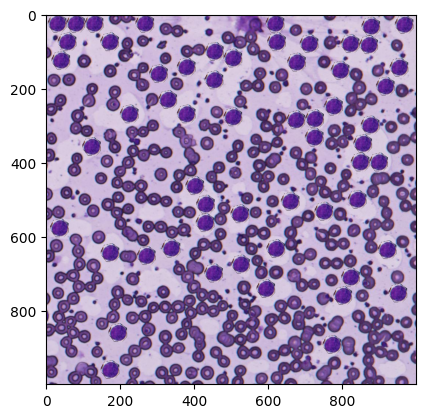

In [196]:
paste_img = no_wbc_img.copy()
mask_img = no_wbc_bin_img.copy()
for row_i in range(mask_img.shape[0] - row_offset + 1):
    for col_i in range(mask_img.shape[1] - col_offset + 1):
        mask_box  = mask_img[row_i:row_i+row_offset, col_i:col_i+col_offset]
        img_box = paste_img[row_i:row_i+row_offset, col_i:col_i+col_offset]
        if np.all(mask_box== 255):
            mask_img[row_i:row_i+row_offset, col_i:col_i+col_offset] = 0
            img_box[image_indices[0], image_indices[1]] = au[0][image_indices[0], image_indices[1]]
        

plt.imshow(paste_img)
plt.show()


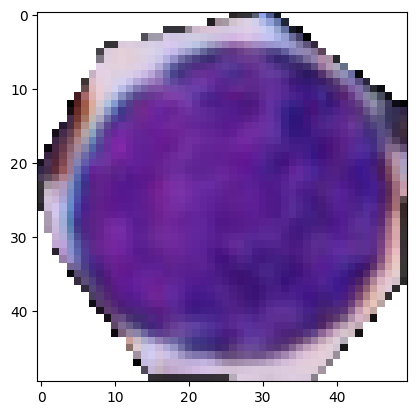

In [200]:
ma = np.ones_like(au[0], dtype=np.int32) *255
ma[image_indices[0], image_indices[1]] = au[0][image_indices[0], image_indices[1]]

plt.imshow(ma)
plt.show()


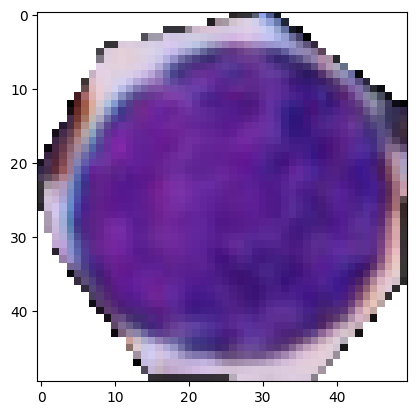

In [207]:
ma = np.ones_like(au[0], dtype=np.int32) *255
ma[image_indices[0], image_indices[1]] = au[0][image_indices[0], image_indices[1]]

# gray_au = cv2.cvtColor(ma, cv2.COLOR_RGB2GRAY)
# _, binary_au = cv2.threshold(gray_au, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# conts = cv2.findContours(gray_au)

plt.imshow(ma)
plt.show()

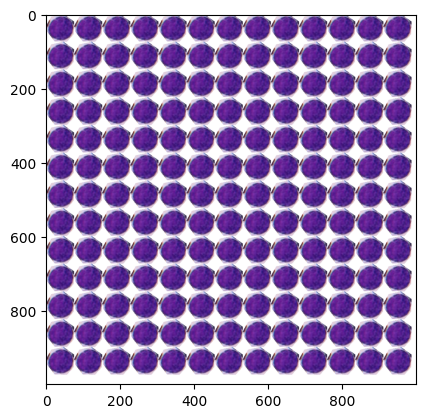

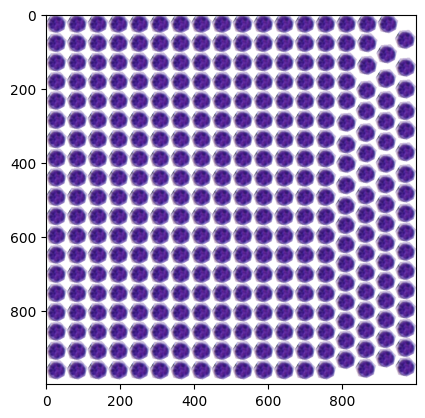

In [18]:

for box in roi_boxes:
    non_zero_mask = np.any(box!=[0,0,0], axis=2)
    white_mask = non_zero_mask * 255
    image_indices = np.where(white_mask!=0)
    img = np.ones((1000,1000,3), dtype=np.int32) * 255
    
    # Get the start and end index of image
    row_start, row_end = np.min(image_indices[0]) , np.max(image_indices[0] + 1)
    col_start, col_end = np.min(image_indices[1]) , np.max(image_indices[1] + 1)
    row_offset, col_offset = row_end-row_start, col_end-col_start
    
    for row_i in range(img.shape[0] - row_offset + 1):
        for col_i in range(img.shape[1] - col_offset + 1):
            img_box = img[row_i:row_i+row_offset, col_i:col_i+col_offset]
            if np.all(img_box == 255):
                img_box[image_indices[0], image_indices[1]] = box[image_indices[0], image_indices[1]]

    plt.imshow(img)
    plt.show()
    

In [19]:
mat = np.zeros((10,10,3), dtype=np.int32)
mat[0,5,:] = [255,0,0]
mat[1,4:7,:] = [255,25,255]
mat[2,5,:] = [255,0,0]

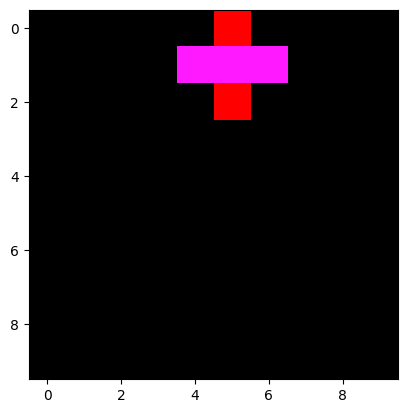

In [20]:
plt.imshow(mat)
plt.show()

In [21]:
non_zero_mask = np.any(mat!=[0,0,0], axis=2)
gray_mask = non_zero_mask * 255

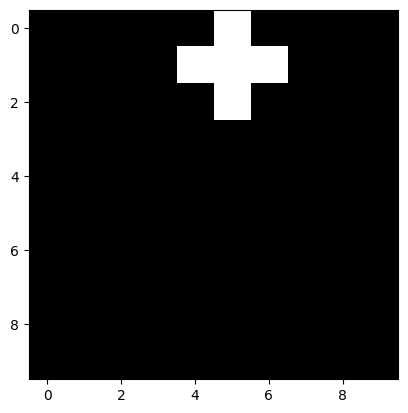

In [22]:
plt.imshow(gray_mask, cmap='gray')
plt.show()

In [23]:
img_indices = np.where(gray_mask!=0)
img_indices

(array([0, 1, 1, 1, 2], dtype=int64), array([5, 4, 5, 6, 5], dtype=int64))

In [24]:
roi_box = mat[np.min(img_indices[0]) : np.max(img_indices[0] + 1), np.min(img_indices[1]) : np.max(img_indices[1] + 1)] 

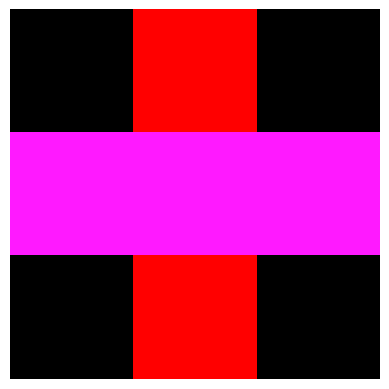

In [25]:
plt.imshow(roi_box)
plt.axis('off')
plt.show()

In [26]:
non_zero_mask_box = np.any(roi_box!=[0,0,0], axis=2)
gray_mask_box = non_zero_mask_box * 255

In [27]:
# 0 -> black, 255-> white
np.all(mat[0:3,0:3] == np.zeros_like(mat[0:3,0:3]))


True

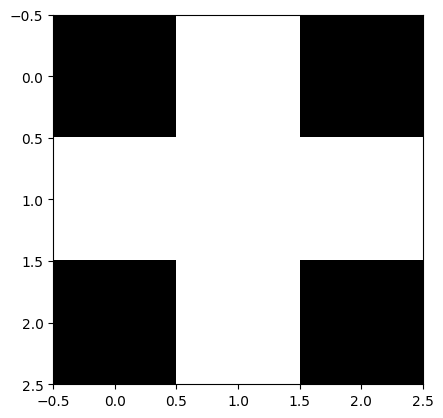

In [28]:
plt.imshow(gray_mask_box, cmap='gray')
plt.show()

In [29]:
shape_indices = np.where(gray_mask_box!=0) 
shape_indices

(array([0, 1, 1, 1, 2], dtype=int64), array([1, 0, 1, 2, 1], dtype=int64))

In [30]:
row_start, row_end = np.min(img_indices[0]) , np.max(img_indices[0] + 1)
col_start, col_end = np.min(img_indices[1]) , np.max(img_indices[1] + 1)

row_offset, col_offset = row_end-row_start, col_end-col_start

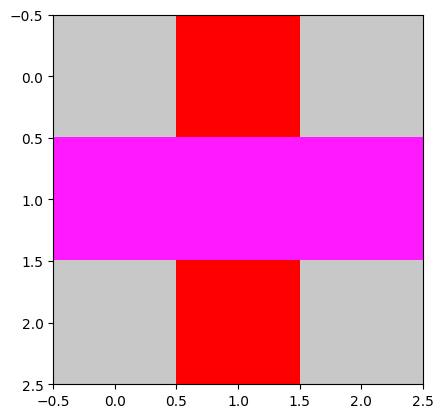

In [31]:
new_box = np.ones_like(roi_box) * 200
new_box[shape_indices[0], shape_indices[1]] = roi_box[shape_indices[0], shape_indices[1]]
plt.imshow(new_box)
plt.show()

In [32]:
for row_i in range(mat.shape[0] - row_offset + 1):
    for col_i in range(mat.shape[1] - col_offset + 1):
        box = mat[row_i:row_i+row_offset, col_i:col_i+col_offset]
        if np.all(box == np.zeros_like(box)):
            box[shape_indices[0], shape_indices[1]] = roi_box[shape_indices[0], shape_indices[1]]

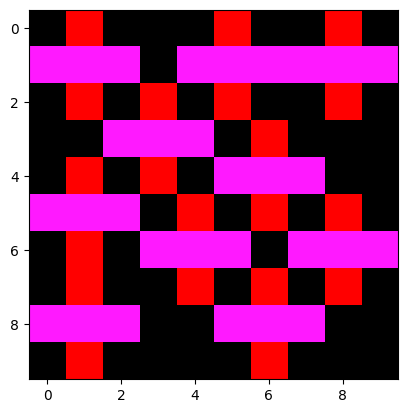

In [33]:
plt.imshow(mat)
plt.show()

#012 Blending and Pasting Images Using OpenCV<br>
https://datahacker.rs/012-blending-and-pasting-images-using-opencv/

In [ ]:
# https://datahacker.rs/012-blending-and-pasting-images-using-opencv/